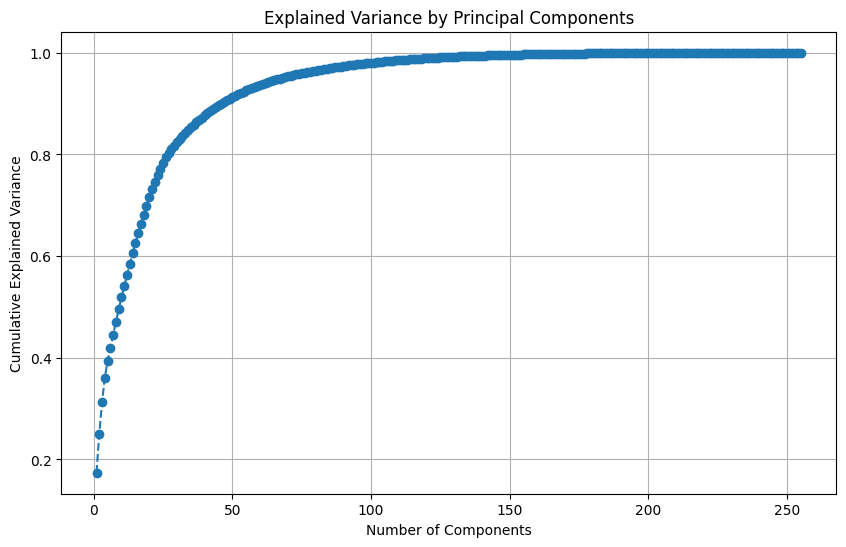


Model: Linear Regression
MAE: 0.2592795634684505
MSE: 0.13607948109963153
RMSE: 0.13607948109963153
R^2: 0.8626489556816295
Training Time: 0.03877902030944824s

Model: Lasso Regression
MAE: 0.4002430360350972
MSE: 0.35712745936920504
RMSE: 0.35712745936920504
R^2: 0.6395354457354734
Training Time: 0.0013203620910644531s

Model: Ridge Regression
MAE: 0.2592704995335292
MSE: 0.13608078797410977
RMSE: 0.13608078797410977
R^2: 0.862647636595365
Training Time: 0.0019872188568115234s

Model: Random Forest
MAE: 0.21284338566470304
MSE: 0.10858892392584998
RMSE: 0.10858892392584998
R^2: 0.8903963920048783
Training Time: 5.968111276626587s

Model: Support Vector Regression
MAE: 0.20433670250552444
MSE: 0.11105286461721627
RMSE: 0.11105286461721627
R^2: 0.8879094275899426
Training Time: 0.21677827835083008s

Model: Artificial Neural Network
MAE: 0.24069717628404744
MSE: 0.11147401544744534
RMSE: 0.11147401544744534
R^2: 0.887484341413246
Training Time: 8.411202430725098s

Model: XGBoost
MAE: 0.

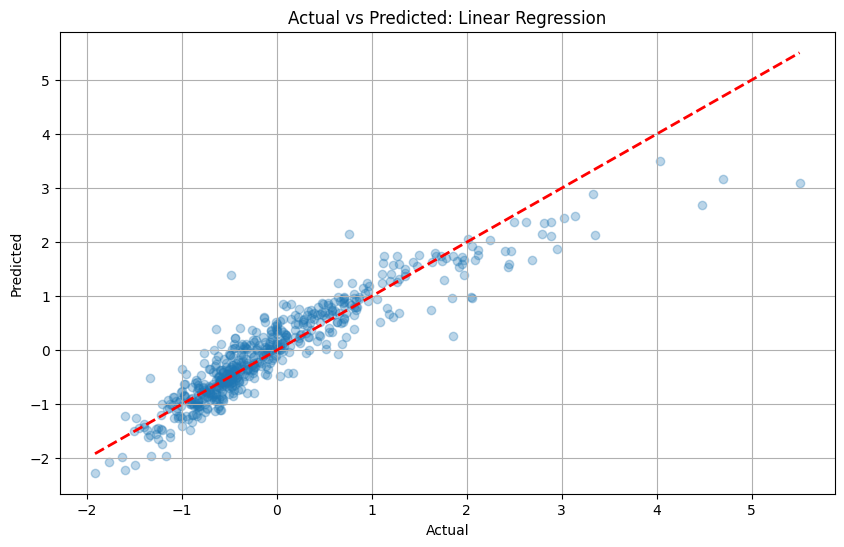

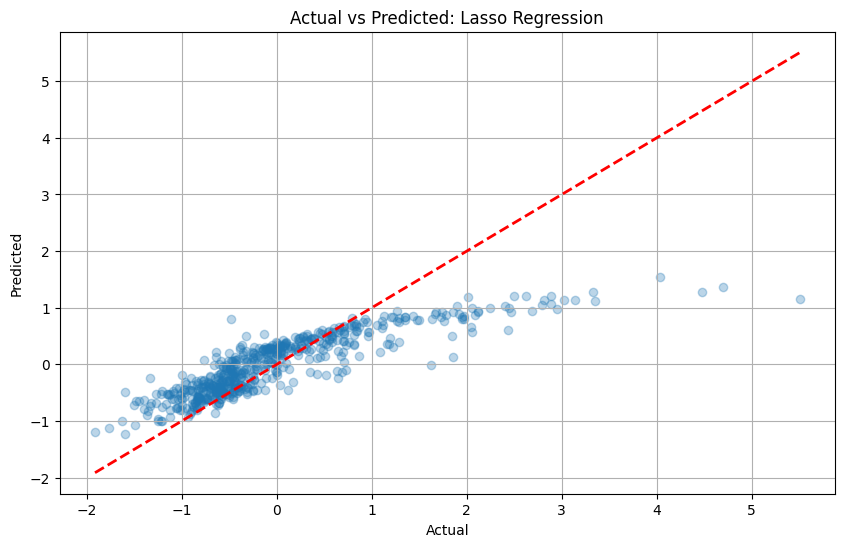

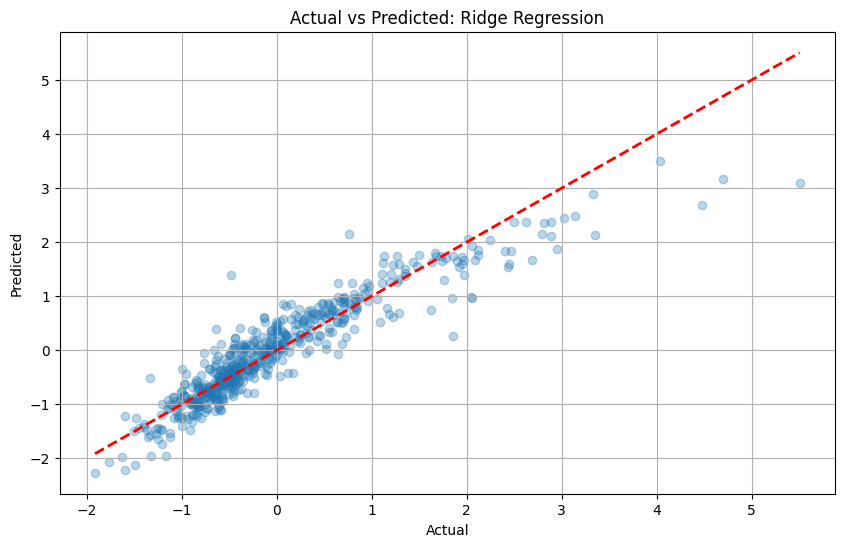

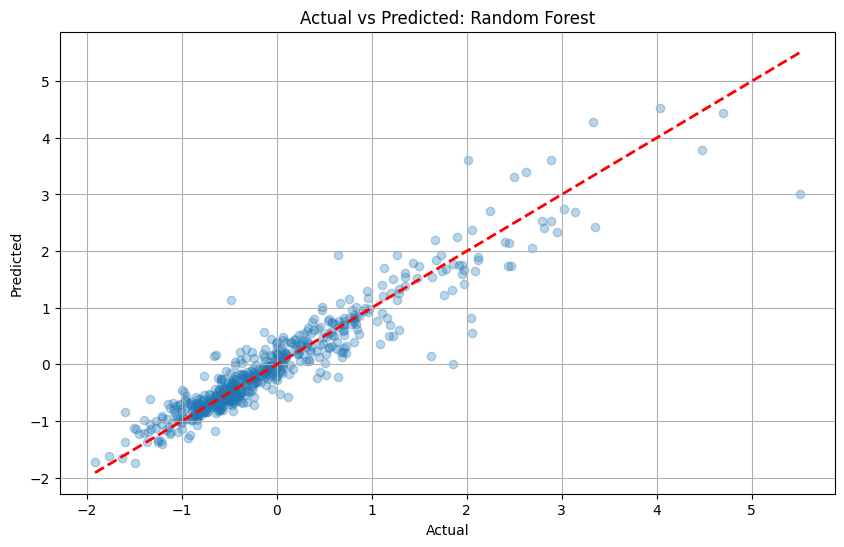

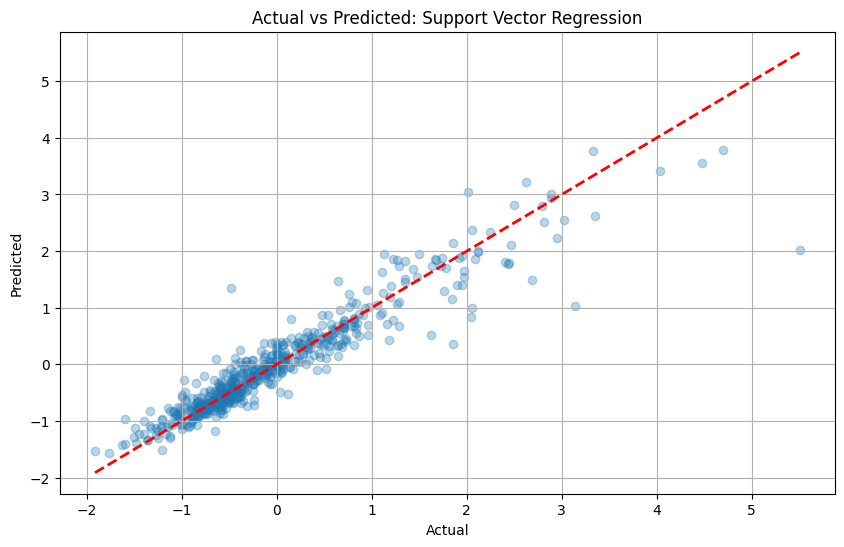

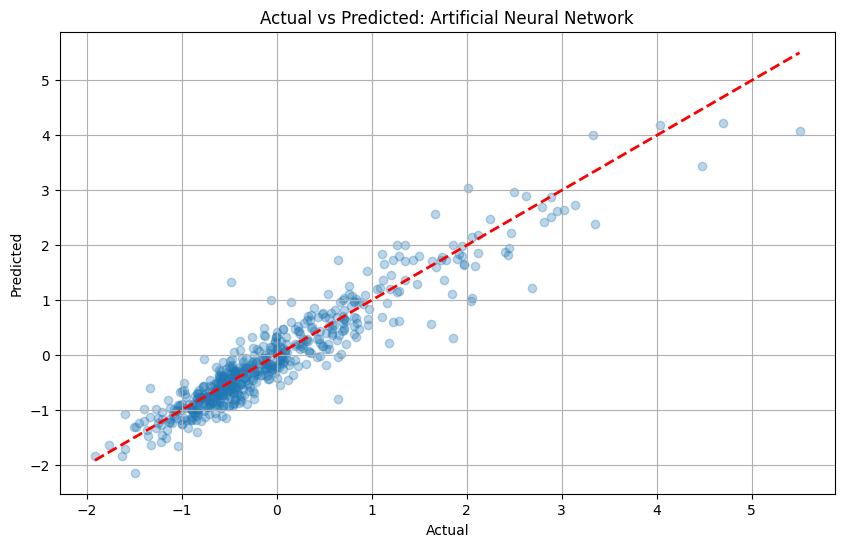

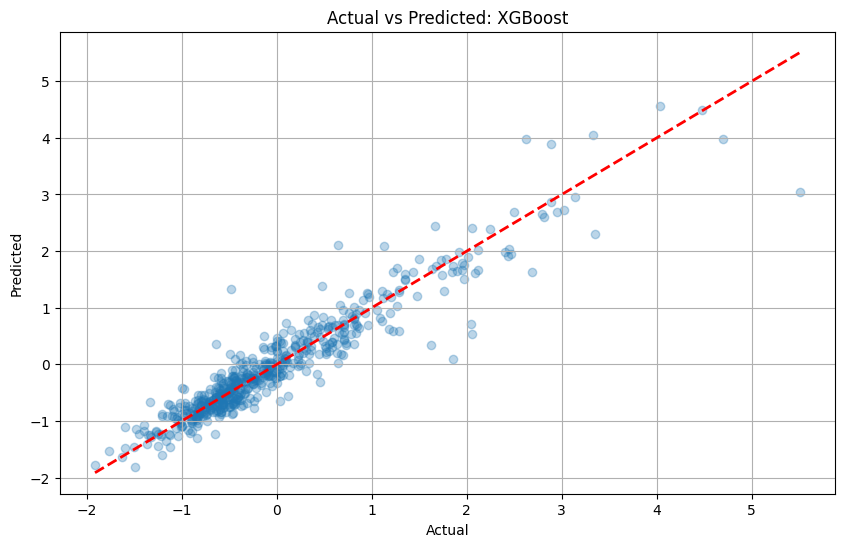

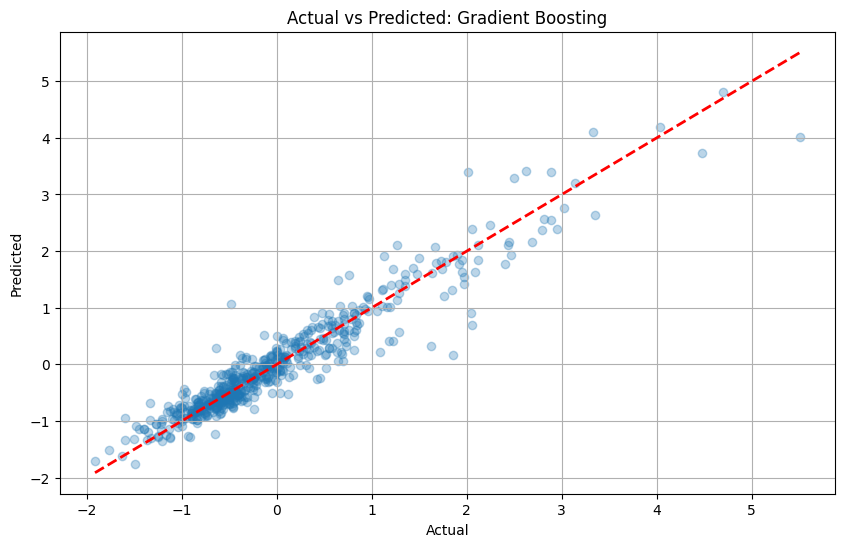

In [3]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import time
import matplotlib.pyplot as plt

# Load the dataset
file_path = '../data/AmesData.csv'
ames_df = pd.read_csv(file_path)

# Preprocess the data
ames_df.replace({'MasVnrArea': 'nan'}, 0, inplace=True)
num_imputer = SimpleImputer(strategy='median')
num_cols_with_missing = ames_df.select_dtypes(include=[np.number]).columns[ames_df.select_dtypes(include=[np.number]).isnull().any()].tolist()
ames_df[num_cols_with_missing] = num_imputer.fit_transform(ames_df[num_cols_with_missing])
cat_imputer = SimpleImputer(strategy='most_frequent')
cat_cols_with_missing = ames_df.select_dtypes(exclude=[np.number]).columns[ames_df.select_dtypes(exclude=[np.number]).isnull().any()].tolist()
ames_df[cat_cols_with_missing] = cat_imputer.fit_transform(ames_df[cat_cols_with_missing])
bool_cols = ames_df.select_dtypes(include=[bool]).columns.tolist()
ames_df[bool_cols] = ames_df[bool_cols].astype(int)
ames_df = ames_df.drop(ames_df[ames_df['GrLivArea'] > 4000].index)
ames_df = pd.get_dummies(ames_df, drop_first=True)
scaler = StandardScaler()
num_features = ames_df.select_dtypes(include=[np.number]).columns.drop('SalePrice')
ames_df[num_features] = scaler.fit_transform(ames_df[num_features])
saleprice_scaler = StandardScaler()
ames_df['SalePrice'] = saleprice_scaler.fit_transform(ames_df['SalePrice'].values.reshape(-1, 1))

# Separate features and target variable
X = ames_df.drop('SalePrice', axis=1)
y = ames_df['SalePrice']

# Fit PCA with the preprocessed data
pca = PCA()
pca.fit(X)

# Plot the cumulative explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), 
         pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')
plt.title('Explained Variance by Principal Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

# Apply PCA
n_components = 20
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Define training and evaluation function
def train_and_evaluate_model(model, model_name, X_train, X_test, y_train, y_test):
    start_time = time.time()
    model.fit(X_train, y_train)
    training_time = time.time() - start_time

    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"\nModel: {model_name}")
    print(f"MAE: {mae}")
    print(f"MSE: {mse}")
    print(f"RMSE: {rmse}")
    print(f"R^2: {r2}")
    print(f"Training Time: {training_time}s")

    return y_pred

# Function to train and evaluate multiple models
def train_and_evaluate_models(X_train, X_test, y_train, y_test):
    models = {
        "Linear Regression": LinearRegression(),
        "Lasso Regression": Lasso(),
        "Ridge Regression": Ridge(),
        "Random Forest": RandomForestRegressor(),
        "Support Vector Regression": SVR(),
        "Artificial Neural Network": MLPRegressor(max_iter=1000),
        "XGBoost": XGBRegressor(),
        "Gradient Boosting": GradientBoostingRegressor()
    }

    predictions = {}

    for model_name, model in models.items():
        y_pred = train_and_evaluate_model(model, model_name, X_train, X_test, y_train, y_test)
        predictions[model_name] = y_pred

    return predictions

# Train and evaluate all models
predictions = train_and_evaluate_models(X_train, X_test, y_train, y_test)

# Function to plot actual vs predicted values
def plot_actual_vs_predicted(y_test, y_pred, model_name):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.3)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'Actual vs Predicted: {model_name}')
    plt.grid(True)
    plt.show()

# Plot actual vs predicted values for all models
for model_name, y_pred in predictions.items():
    plot_actual_vs_predicted(y_test, y_pred, model_name)


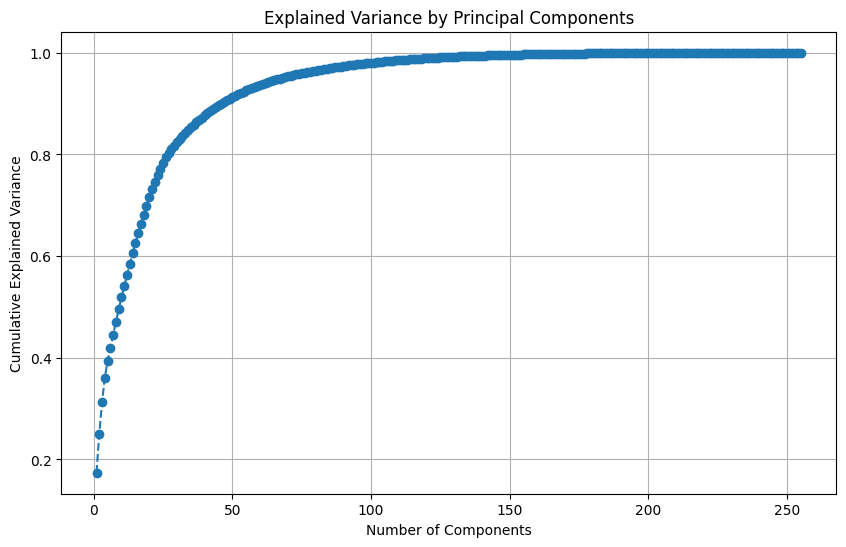


Model: Linear Regression
MAE (in USD): $20271.060594708164
MSE: 831781036.0735319
RMSE: 831781036.0735319
R^2: 0.8626489556816295
Training Time: 0.0954751968383789s

Model: Lasso Regression
MAE (in USD): $31291.90256086135
MSE: 2182929018.8646216
RMSE: 2182929018.8646216
R^2: 0.6395354457354734
Training Time: 0.00099945068359375s

Model: Ridge Regression
MAE (in USD): $20270.35195584917
MSE: 831789024.2977574
RMSE: 831789024.2977574
R^2: 0.8626476365953651
Training Time: 0.0009922981262207031s

Model: Random Forest
MAE (in USD): $16893.828655816757
MSE: 687818806.7702248
RMSE: 687818806.7702248
R^2: 0.8864212727694909
Training Time: 5.465327739715576s

Model: Support Vector Regression
MAE (in USD): $15975.50390320817
MSE: 678806724.1571215
RMSE: 678806724.1571215
R^2: 0.8879094275899426
Training Time: 0.17021703720092773s

Model: Artificial Neural Network
MAE (in USD): $17419.12469882729
MSE: 631120388.2745624
RMSE: 631120388.2745624
R^2: 0.8957838173020533
Training Time: 6.9475250244

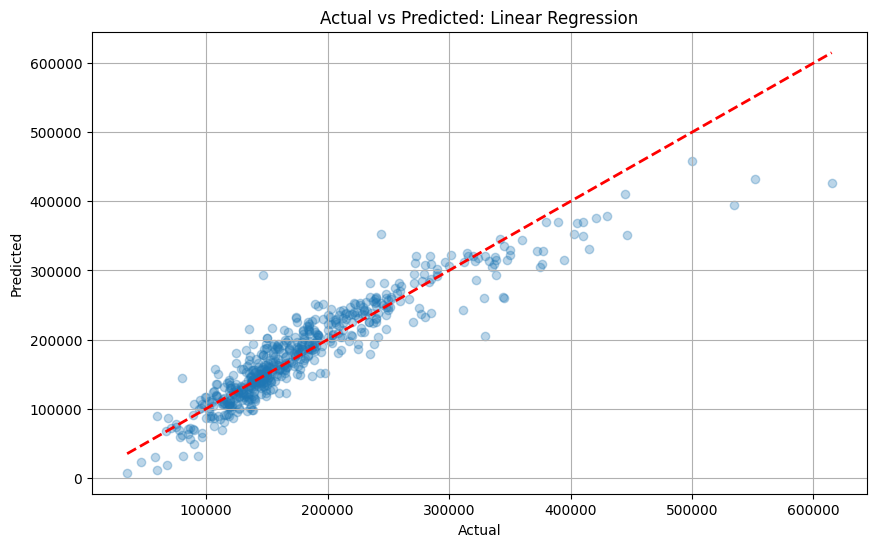

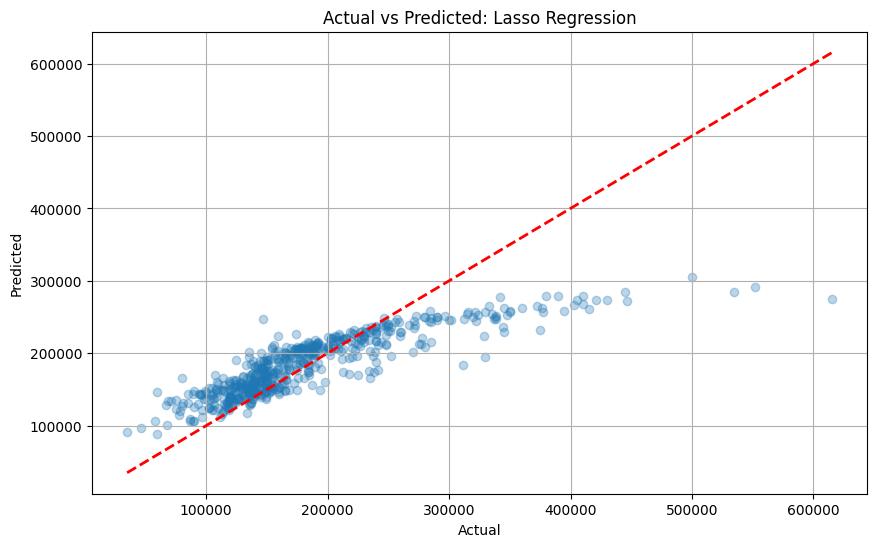

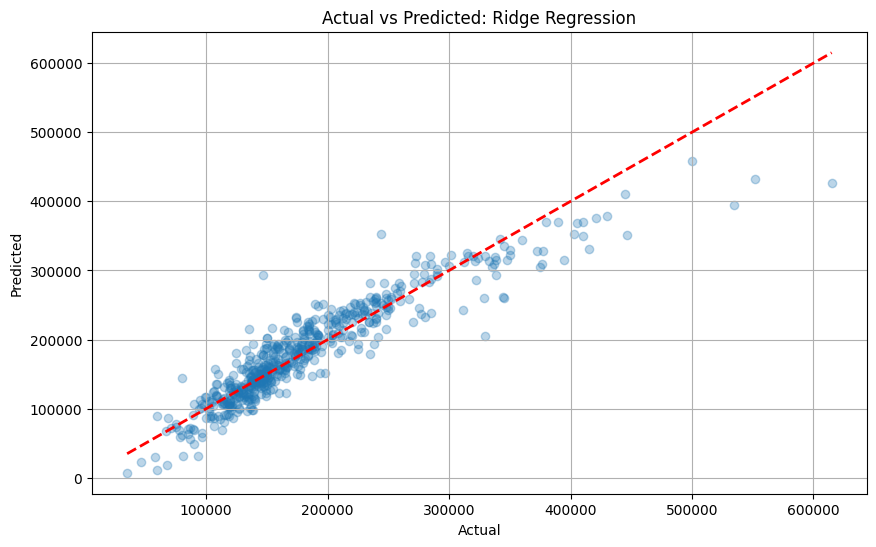

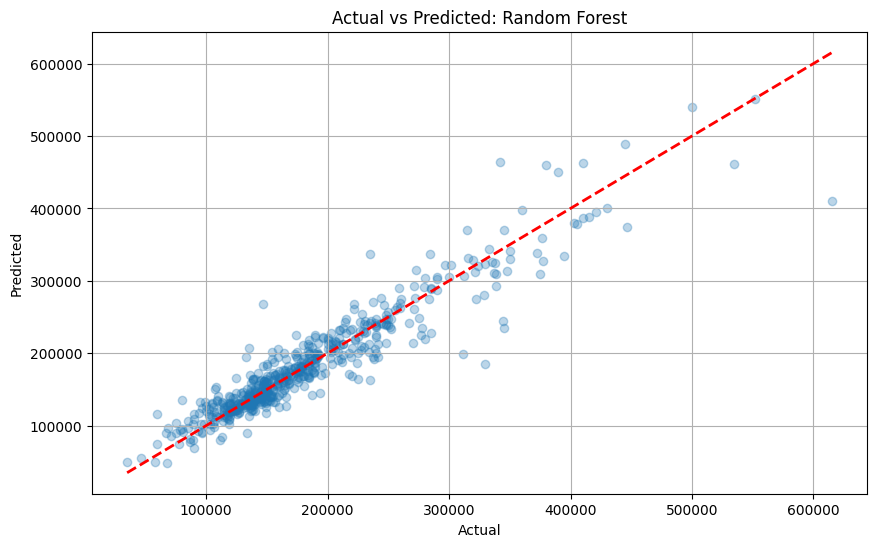

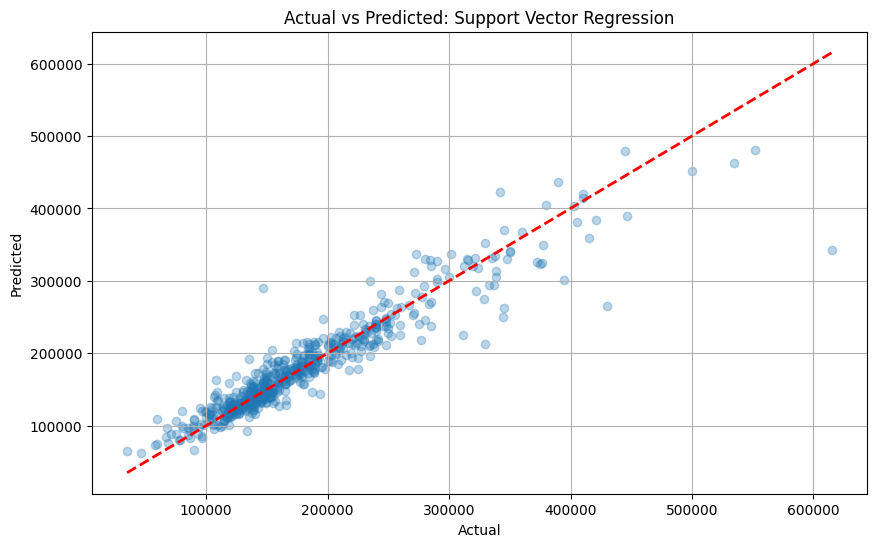

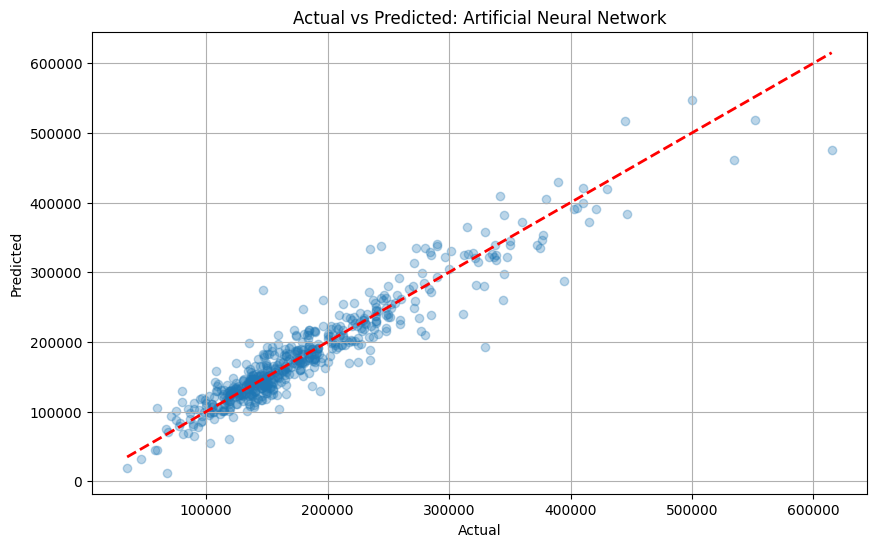

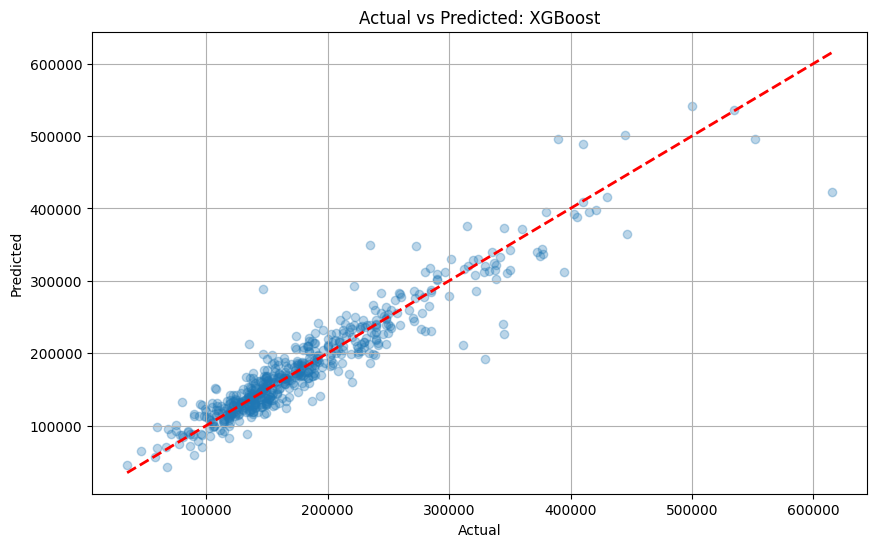

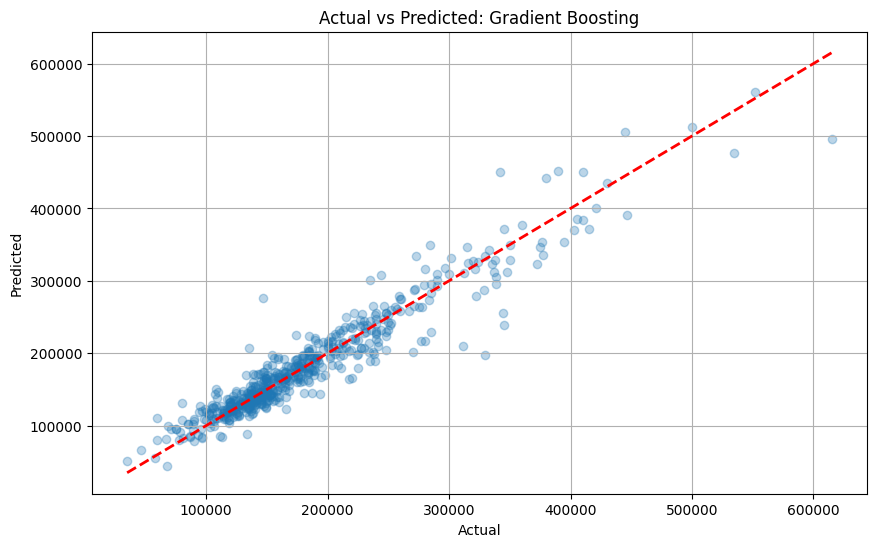

c:\Users\odpol\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
120 fits failed out of a total of 240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
52 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\odpol\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\odpol\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\Users\odpol\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.

Best parameters for RandomForestRegressor: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

Model: Optimized Random Forest
MAE (in USD): $17383.038437074185
MSE: 710941889.9752948
RMSE: 710941889.9752948
R^2: 0.8826029846764258
Training Time: 3.0890462398529053s


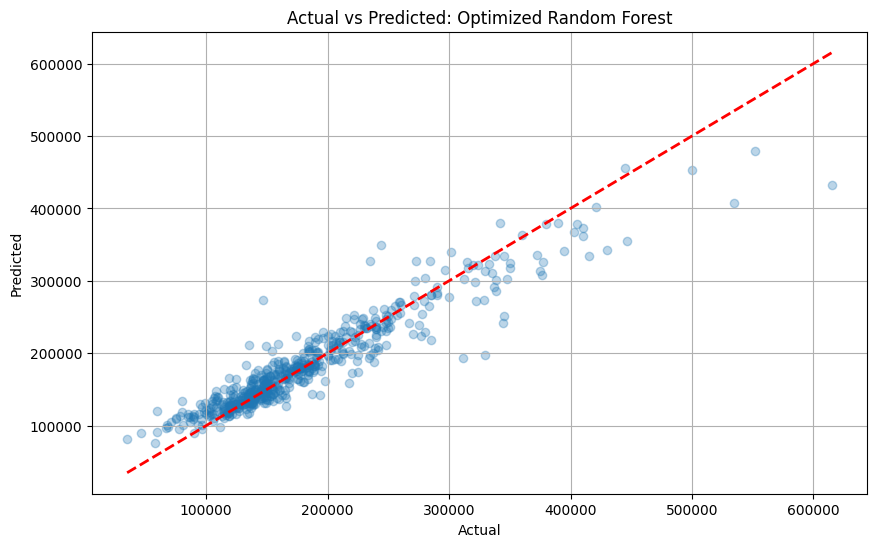

In [4]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import time
import matplotlib.pyplot as plt

# Load the dataset
file_path = '../data/AmesData.csv'
ames_df = pd.read_csv(file_path)

# Preprocess the data
ames_df.replace({'MasVnrArea': 'nan'}, 0, inplace=True)
num_imputer = SimpleImputer(strategy='median')
num_cols_with_missing = ames_df.select_dtypes(include=[np.number]).columns[ames_df.select_dtypes(include=[np.number]).isnull().any()].tolist()
ames_df[num_cols_with_missing] = num_imputer.fit_transform(ames_df[num_cols_with_missing])
cat_imputer = SimpleImputer(strategy='most_frequent')
cat_cols_with_missing = ames_df.select_dtypes(exclude=[np.number]).columns[ames_df.select_dtypes(exclude=[np.number]).isnull().any()].tolist()
ames_df[cat_cols_with_missing] = cat_imputer.fit_transform(ames_df[cat_cols_with_missing])
bool_cols = ames_df.select_dtypes(include=[bool]).columns.tolist()
ames_df[bool_cols] = ames_df[bool_cols].astype(int)
ames_df = ames_df.drop(ames_df[ames_df['GrLivArea'] > 4000].index)
ames_df = pd.get_dummies(ames_df, drop_first=True)
scaler = StandardScaler()
num_features = ames_df.select_dtypes(include=[np.number]).columns.drop('SalePrice')
ames_df[num_features] = scaler.fit_transform(ames_df[num_features])
saleprice_scaler = StandardScaler()
ames_df['SalePrice'] = saleprice_scaler.fit_transform(ames_df['SalePrice'].values.reshape(-1, 1))

# Separate features and target variable
X = ames_df.drop('SalePrice', axis=1)
y = ames_df['SalePrice']

# Fit PCA with the preprocessed data
pca = PCA()
pca.fit(X)

# Plot the cumulative explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), 
         pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')
plt.title('Explained Variance by Principal Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

# Apply PCA
n_components = 20
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Define training and evaluation function
def train_and_evaluate_model(model, model_name, X_train, X_test, y_train, y_test):
    start_time = time.time()
    model.fit(X_train, y_train)
    training_time = time.time() - start_time

    y_pred = model.predict(X_test)

    # Reverse scale the predictions and true values
    y_test_usd = saleprice_scaler.inverse_transform(y_test.values.reshape(-1, 1))
    y_pred_usd = saleprice_scaler.inverse_transform(y_pred.reshape(-1, 1))

    mae = mean_absolute_error(y_test_usd, y_pred_usd)
    mse = mean_squared_error(y_test_usd, y_pred_usd)
    rmse = mean_squared_error(y_test_usd, y_pred_usd)
    r2 = r2_score(y_test_usd, y_pred_usd)

    print(f"\nModel: {model_name}")
    print(f"MAE (in USD): ${mae}")
    print(f"MSE: {mse}")
    print(f"RMSE: {rmse}")
    print(f"R^2: {r2}")
    print(f"Training Time: {training_time}s")

    return y_pred

# Function to train and evaluate multiple models
def train_and_evaluate_models(X_train, X_test, y_train, y_test):
    models = {
        "Linear Regression": LinearRegression(),
        "Lasso Regression": Lasso(),
        "Ridge Regression": Ridge(),
        "Random Forest": RandomForestRegressor(),
        "Support Vector Regression": SVR(),
        "Artificial Neural Network": MLPRegressor(max_iter=1000),
        "XGBoost": XGBRegressor(),
        "Gradient Boosting": GradientBoostingRegressor()
    }

    predictions = {}

    for model_name, model in models.items():
        y_pred = train_and_evaluate_model(model, model_name, X_train, X_test, y_train, y_test)
        predictions[model_name] = y_pred

    return predictions

# Train and evaluate all models
predictions = train_and_evaluate_models(X_train, X_test, y_train, y_test)

# Function to plot actual vs predicted values
def plot_actual_vs_predicted(y_test, y_pred, model_name):
    y_test_usd = saleprice_scaler.inverse_transform(y_test.values.reshape(-1, 1))
    y_pred_usd = saleprice_scaler.inverse_transform(y_pred.reshape(-1, 1))

    plt.figure(figsize=(10, 6))
    plt.scatter(y_test_usd, y_pred_usd, alpha=0.3)
    plt.plot([y_test_usd.min(), y_test_usd.max()], [y_test_usd.min(), y_test_usd.max()], 'r--', linewidth=2)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'Actual vs Predicted: {model_name}')
    plt.grid(True)
    plt.show()

# Plot actual vs predicted values for all models
for model_name, y_pred in predictions.items():
    plot_actual_vs_predicted(y_test, y_pred, model_name)

# Hyperparameter tuning function
def hyperparameter_tuning(model, param_grid, X_train, y_train):
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_mean_absolute_error')
    grid_search.fit(X_train, y_train)
    print(f"Best parameters for {model.__class__.__name__}: {grid_search.best_params_}")
    return grid_search.best_estimator_

# Example of hyperparameter tuning for Random Forest
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_features': ['auto', 'sqrt'],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
}

best_rf = hyperparameter_tuning(RandomForestRegressor(), rf_param_grid, X_train, y_train)
y_pred_best_rf = train_and_evaluate_model(best_rf, "Optimized Random Forest", X_train, X_test, y_train, y_test)

# Plot for optimized Random Forest
plot_actual_vs_predicted(y_test, y_pred_best_rf, "Optimized Random Forest")


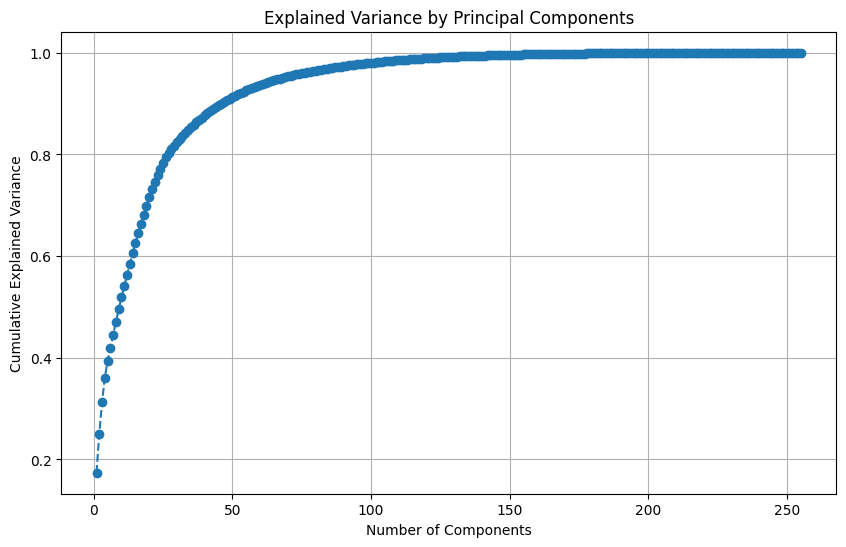


Model: Linear Regression
MAE (in USD): $20271.060594708164
MSE: 831781036.0735319
RMSE: 28840.614349793796
R^2: 0.8626489556816295
Training Time: 0.1390082836151123s

Model: Lasso Regression
MAE (in USD): $31291.90256086135
MSE: 2182929018.8646216
RMSE: 46721.82593675703
R^2: 0.6395354457354734
Training Time: 0.0010042190551757812s

Model: Ridge Regression
MAE (in USD): $20270.35195584917
MSE: 831789024.2977574
RMSE: 28840.75283860942
R^2: 0.8626476365953651
Training Time: 0.002007007598876953s

Model: Elastic Net
MAE (in USD): $27907.81937186
MSE: 1736188404.635449
RMSE: 41667.59417863538
R^2: 0.713305208741206
Training Time: 0.0010006427764892578s

Model: Random Forest
MAE (in USD): $16799.118776371306
MSE: 693413754.2419374
RMSE: 26332.750601521624
R^2: 0.8854973855385753
Training Time: 5.443054914474487s

Model: Support Vector Regression
MAE (in USD): $15975.50390320817
MSE: 678806724.1571215
RMSE: 26053.919554591426
R^2: 0.8879094275899426
Training Time: 0.17368078231811523s

Mod

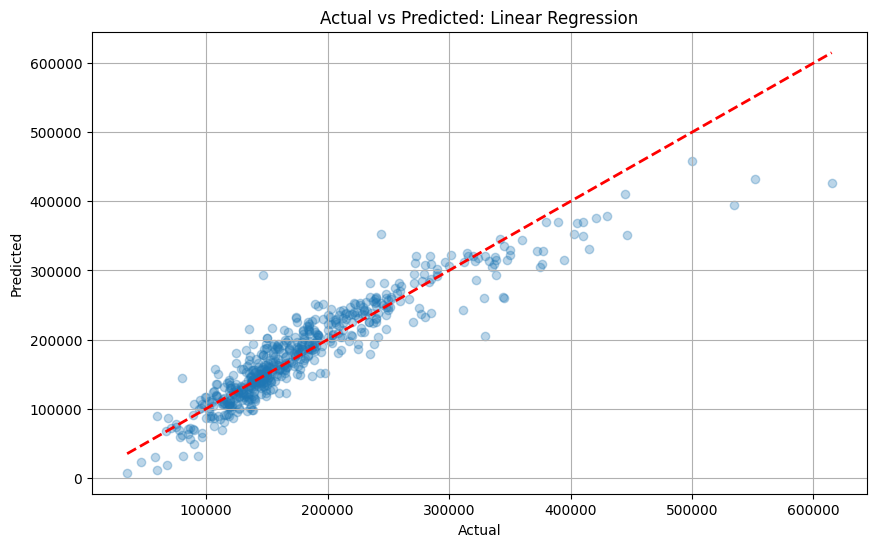

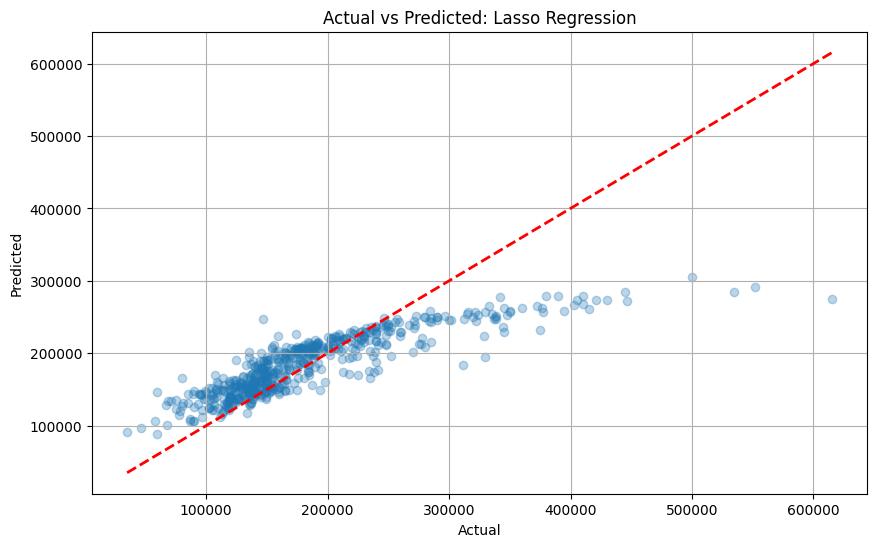

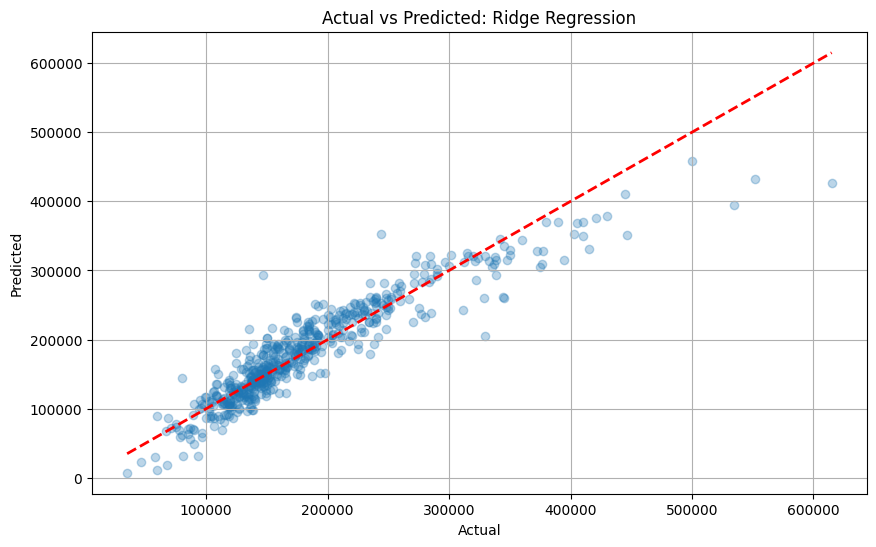

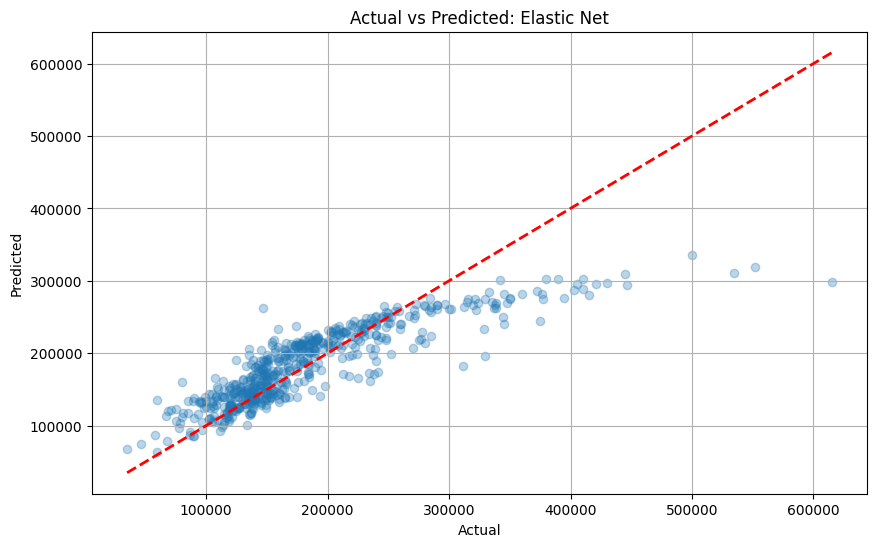

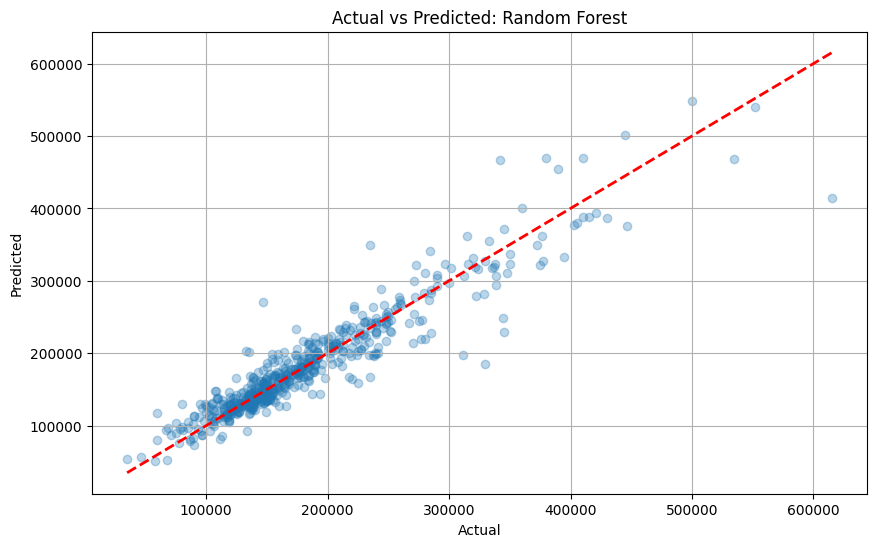

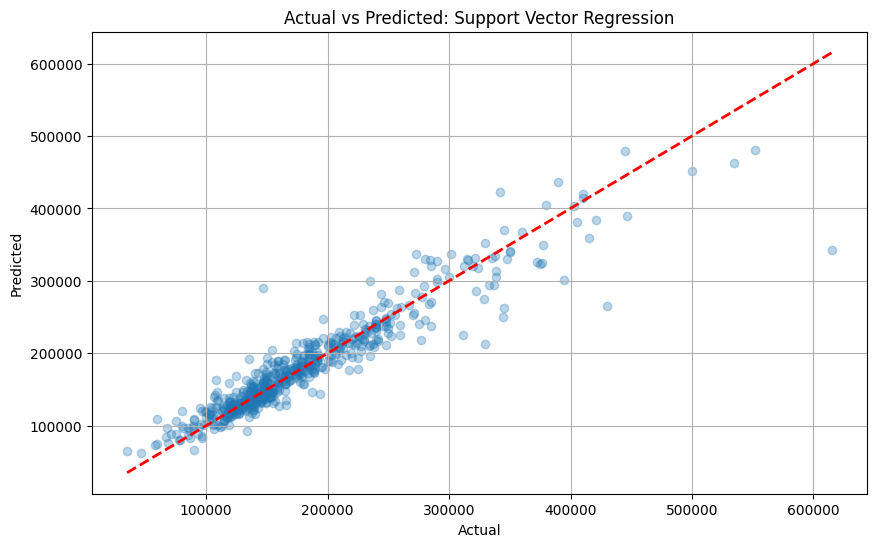

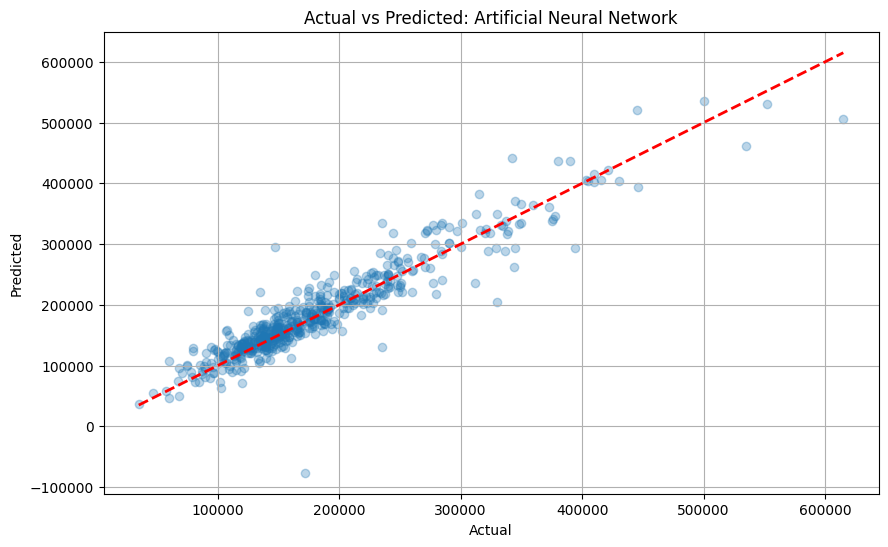

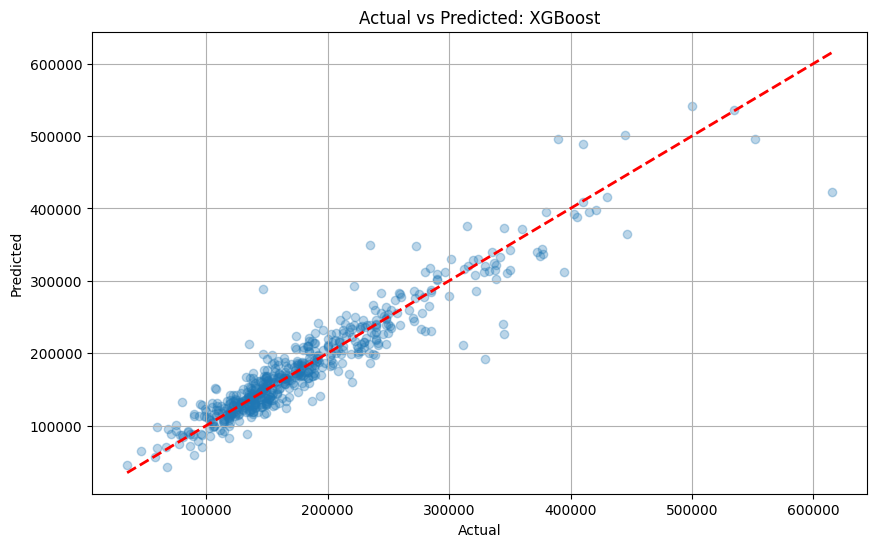

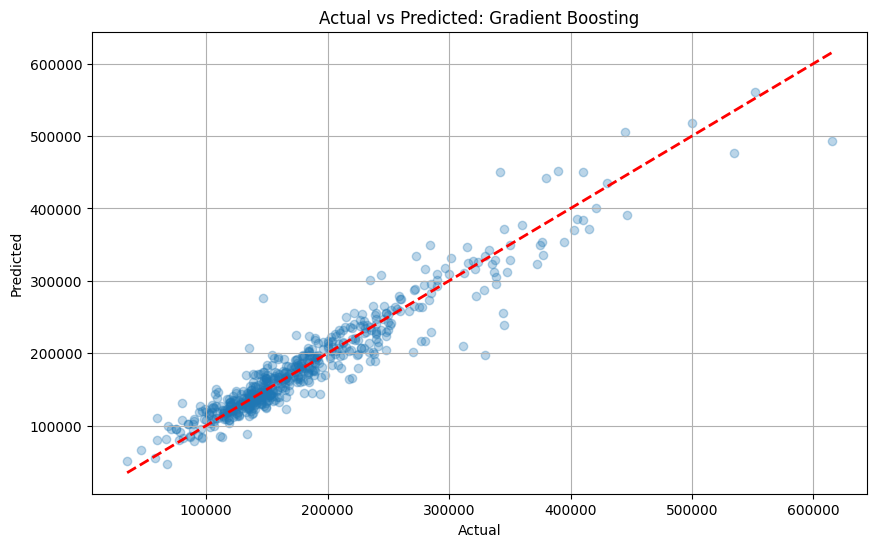


Hyperparameter tuning for Random Forest
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


c:\Users\odpol\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters for RandomForestRegressor: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None, 'bootstrap': False}

Model: Optimized Random Forest
MAE (in USD): $16838.6897166968
MSE: 679983047.3678708
RMSE: 26076.484566901858
R^2: 0.8877151826932147
Training Time: 6.446331024169922s


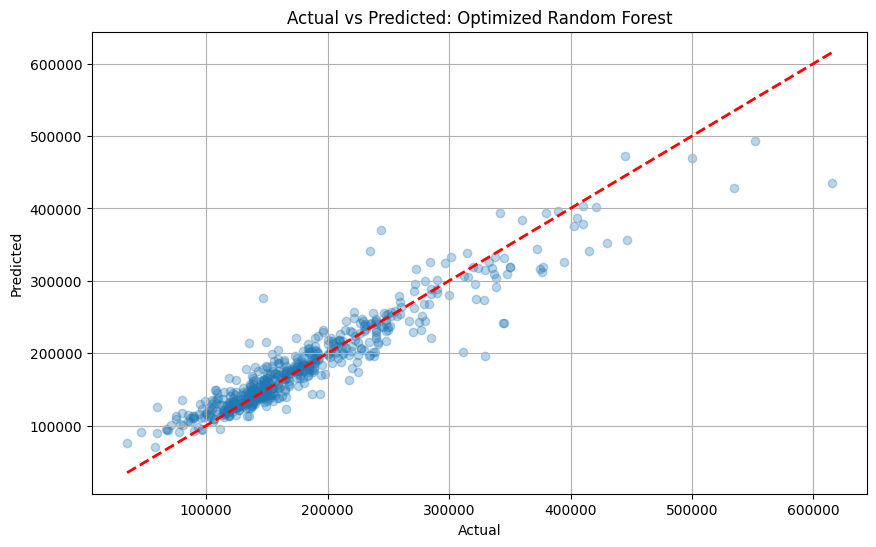


Hyperparameter tuning for Lasso Regression
Fitting 5 folds for each of 13 candidates, totalling 65 fits
Best parameters for Lasso: {'alpha': 0.001}

Model: Optimized Lasso Regression
MAE (in USD): $20268.93603919358
MSE: 832831694.9819647
RMSE: 28858.823520406455
R^2: 0.8624754615863843
Training Time: 0.001990079879760742s


c:\Users\odpol\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 13 is smaller than n_iter=200. Running 13 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


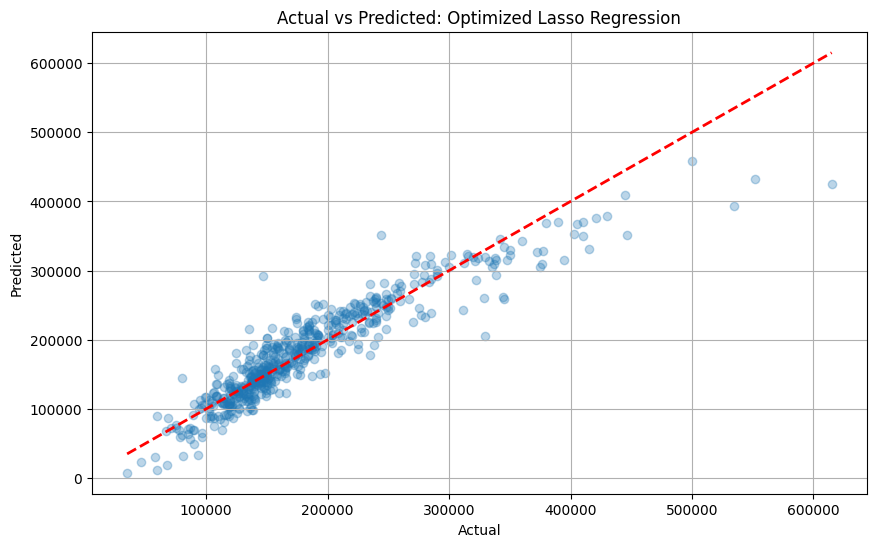


Hyperparameter tuning for Ridge Regression
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters for Ridge: {'alpha': 100}

Model: Optimized Ridge Regression
MAE (in USD): $20204.42711492621
MSE: 833100299.9335686
RMSE: 28863.4769203845
R^2: 0.8624311071601449
Training Time: 0.002055644989013672s


c:\Users\odpol\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 4 is smaller than n_iter=200. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


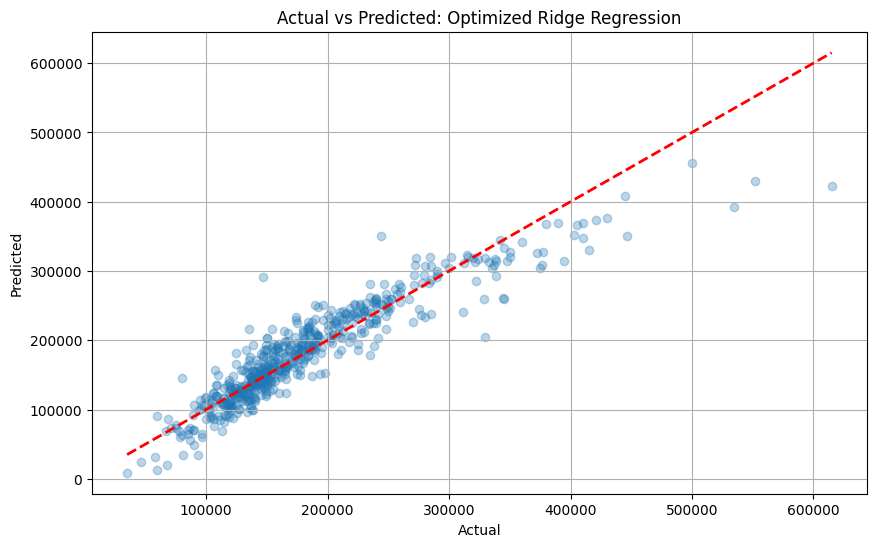


Hyperparameter tuning for Elastic Net
Fitting 5 folds for each of 52 candidates, totalling 260 fits


c:\Users\odpol\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 52 is smaller than n_iter=200. Running 52 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best parameters for ElasticNet: {'l1_ratio': 0.5, 'alpha': 0.01}

Model: Optimized Elastic Net
MAE (in USD): $20274.662533669256
MSE: 838704959.7981803
RMSE: 28960.40330862435
R^2: 0.8615056161329779
Training Time: 0.0002880096435546875s


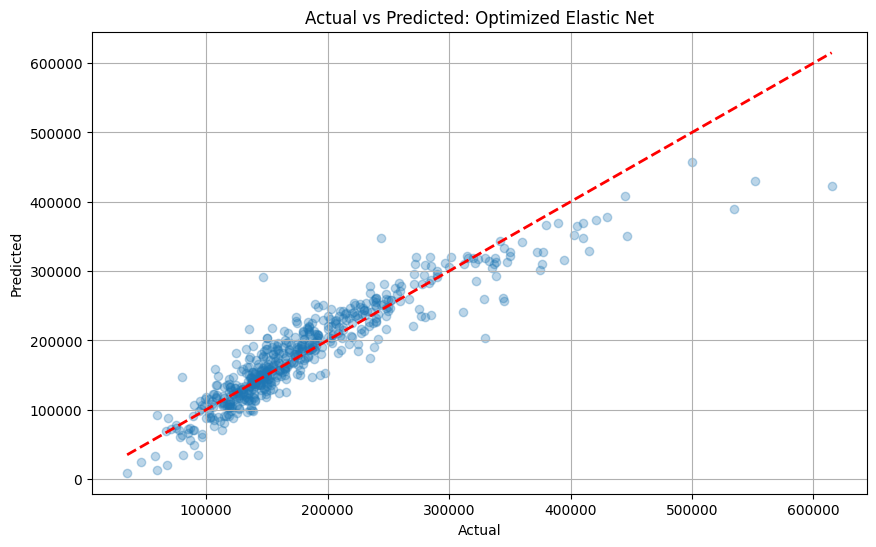


Hyperparameter tuning for XGBoost
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


c:\Users\odpol\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters for XGBRegressor: {'subsample': 0.6, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 0.8}

Model: Optimized XGBoost
MAE (in USD): $15845.51038370253
MSE: 558675736.8983635
RMSE: 23636.32240638047
R^2: 0.907746519131338
Training Time: 0.23438811302185059s


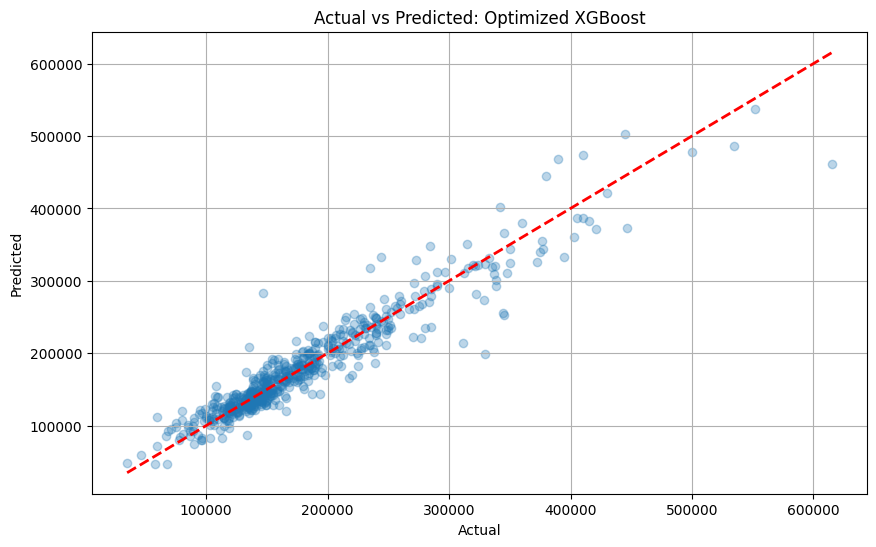


Hyperparameter tuning for Gradient Boosting
Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Best parameters for GradientBoostingRegressor: {'subsample': 0.6, 'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.01}

Model: Optimized Gradient Boosting
MAE (in USD): $15957.589855066853
MSE: 614893295.7598115
RMSE: 24797.042076824637
R^2: 0.8984633783962482
Training Time: 29.250945806503296s


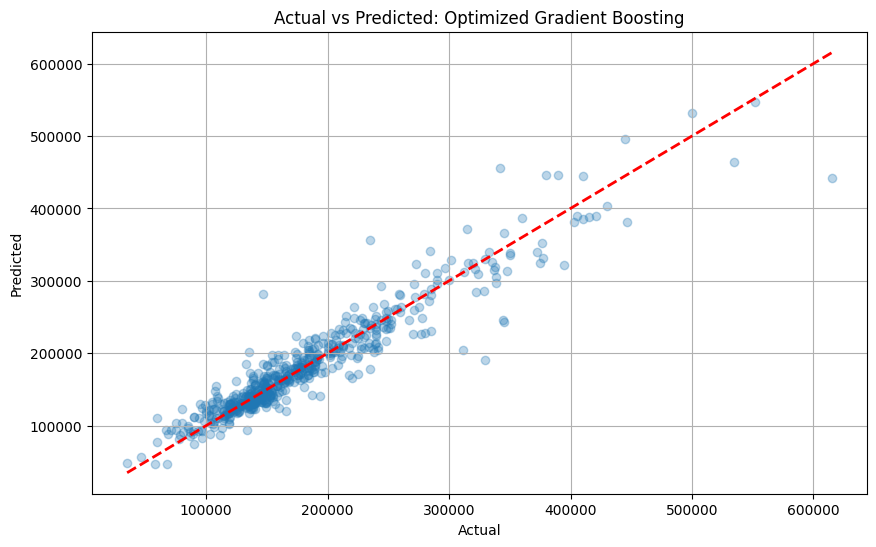


Hyperparameter tuning for Support Vector Regression
Fitting 5 folds for each of 36 candidates, totalling 180 fits


c:\Users\odpol\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 36 is smaller than n_iter=200. Running 36 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best parameters for SVR: {'kernel': 'rbf', 'epsilon': 0.1, 'C': 1}

Model: Optimized Support Vector Regression
MAE (in USD): $15975.50390320817
MSE: 678806724.1571215
RMSE: 26053.919554591426
R^2: 0.8879094275899426
Training Time: 0.5228400230407715s


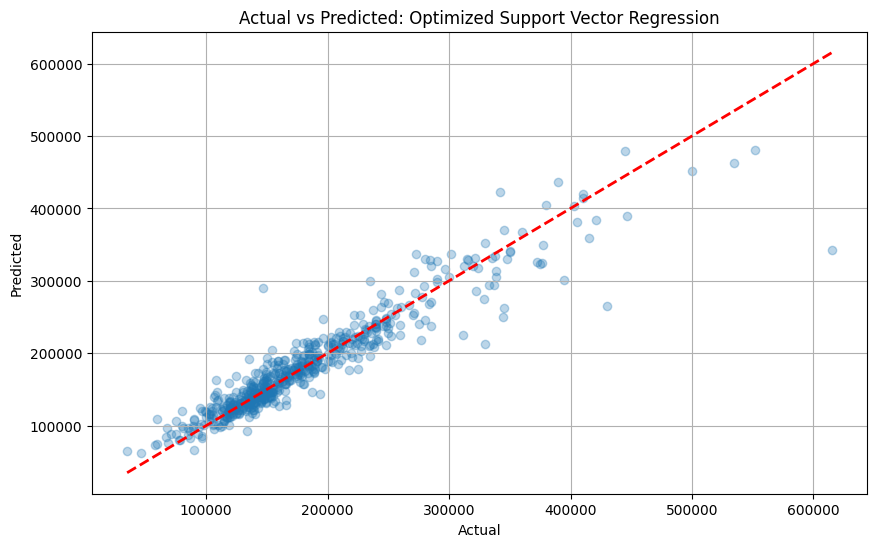


Hyperparameter tuning for Artificial Neural Network
Fitting 5 folds for each of 48 candidates, totalling 240 fits


c:\Users\odpol\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 48 is smaller than n_iter=200. Running 48 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\odpol\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Best parameters for MLPRegressor: {'solver': 'sgd', 'learning_rate': 'adaptive', 'hidden_layer_sizes': (100, 100, 100), 'alpha': 1, 'activation': 'relu'}

Model: Optimized Artificial Neural Network
MAE (in USD): $14842.78960214833
MSE: 497171938.4196155
RMSE: 22297.352722231746
R^2: 0.9179025705249596
Training Time: 105.79703068733215s


c:\Users\odpol\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


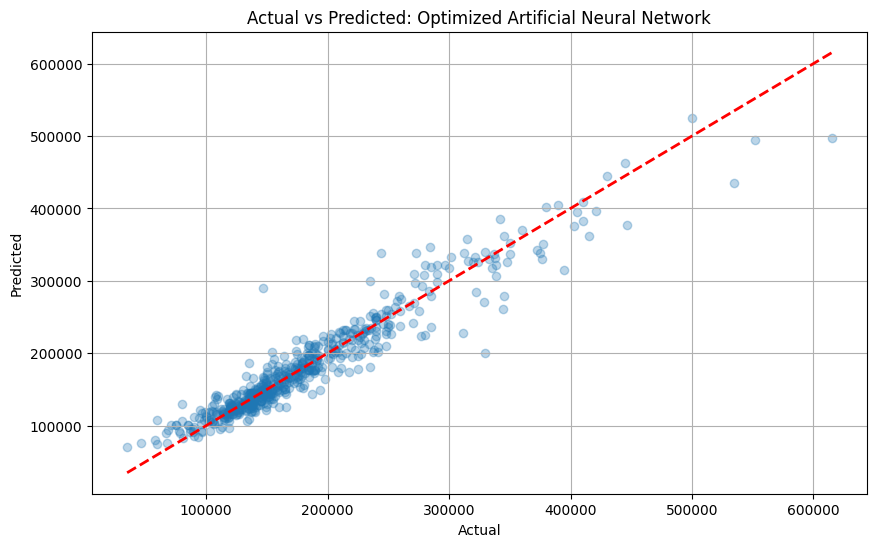

In [5]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, root_mean_squared_error
import time
import matplotlib.pyplot as plt

# Load the dataset
file_path = '../data/AmesData.csv'
ames_df = pd.read_csv(file_path)

# Preprocess the data
ames_df.replace({'MasVnrArea': 'nan'}, 0, inplace=True)
num_imputer = SimpleImputer(strategy='median')
num_cols_with_missing = ames_df.select_dtypes(include=[np.number]).columns[ames_df.select_dtypes(include=[np.number]).isnull().any()].tolist()
ames_df[num_cols_with_missing] = num_imputer.fit_transform(ames_df[num_cols_with_missing])
cat_imputer = SimpleImputer(strategy='most_frequent')
cat_cols_with_missing = ames_df.select_dtypes(exclude=[np.number]).columns[ames_df.select_dtypes(exclude=[np.number]).isnull().any()].tolist()
ames_df[cat_cols_with_missing] = cat_imputer.fit_transform(ames_df[cat_cols_with_missing])
bool_cols = ames_df.select_dtypes(include=[bool]).columns.tolist()
ames_df[bool_cols] = ames_df[bool_cols].astype(int)
ames_df = ames_df.drop(ames_df[ames_df['GrLivArea'] > 4000].index)
ames_df = pd.get_dummies(ames_df, drop_first=True)
scaler = StandardScaler()
num_features = ames_df.select_dtypes(include=[np.number]).columns.drop('SalePrice')
ames_df[num_features] = scaler.fit_transform(ames_df[num_features])
saleprice_scaler = StandardScaler()
ames_df['SalePrice'] = saleprice_scaler.fit_transform(ames_df['SalePrice'].values.reshape(-1, 1))

# Separate features and target variable
X = ames_df.drop('SalePrice', axis=1)
y = ames_df['SalePrice']

# Fit PCA with the preprocessed data
pca = PCA()
pca.fit(X)

# Plot the cumulative explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), 
         pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')
plt.title('Explained Variance by Principal Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

# Apply PCA
n_components = 20
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Define training and evaluation function
def train_and_evaluate_model(model, model_name, X_train, X_test, y_train, y_test):
    start_time = time.time()
    model.fit(X_train, y_train)
    training_time = time.time() - start_time

    y_pred = model.predict(X_test)

    # Reverse scale the predictions and true values
    y_test_usd = saleprice_scaler.inverse_transform(y_test.values.reshape(-1, 1))
    y_pred_usd = saleprice_scaler.inverse_transform(y_pred.reshape(-1, 1))

    mae = mean_absolute_error(y_test_usd, y_pred_usd)
    mse = mean_squared_error(y_test_usd, y_pred_usd)
    rmse = root_mean_squared_error(y_test_usd, y_pred_usd)
    r2 = r2_score(y_test_usd, y_pred_usd)

    print(f"\nModel: {model_name}")
    print(f"MAE (in USD): ${mae}")
    print(f"MSE: {mse}")
    print(f"RMSE: {rmse}")
    print(f"R^2: {r2}")
    print(f"Training Time: {training_time}s")

    return y_pred

# Define models for baseline and hyperparameter tuning
models = {
    "Linear Regression": LinearRegression(),
    "Lasso Regression": Lasso(),
    "Ridge Regression": Ridge(),
    "Elastic Net": ElasticNet(),
    "Random Forest": RandomForestRegressor(),
    "Support Vector Regression": SVR(),
    "Artificial Neural Network": MLPRegressor(max_iter=1000),
    "XGBoost": XGBRegressor(),
    "Gradient Boosting": GradientBoostingRegressor()
}

# Function to train and evaluate multiple models
def train_and_evaluate_models(X_train, X_test, y_train, y_test):
    predictions = {}

    for model_name, model in models.items():
        y_pred = train_and_evaluate_model(model, model_name, X_train, X_test, y_train, y_test)
        predictions[model_name] = y_pred

    return predictions

# Train and evaluate all models
predictions = train_and_evaluate_models(X_train, X_test, y_train, y_test)

# Function to plot actual vs predicted values
def plot_actual_vs_predicted(y_test, y_pred, model_name):
    y_test_usd = saleprice_scaler.inverse_transform(y_test.values.reshape(-1, 1))
    y_pred_usd = saleprice_scaler.inverse_transform(y_pred.reshape(-1, 1))

    plt.figure(figsize=(10, 6))
    plt.scatter(y_test_usd, y_pred_usd, alpha=0.3)
    plt.plot([y_test_usd.min(), y_test_usd.max()], [y_test_usd.min(), y_test_usd.max()], 'r--', linewidth=2)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'Actual vs Predicted: {model_name}')
    plt.grid(True)
    plt.show()

# Plot actual vs predicted values for all models
for model_name, y_pred in predictions.items():
    plot_actual_vs_predicted(y_test, y_pred, model_name)

# Hyperparameter tuning function
def hyperparameter_tuning(model, param_grid, X_train, y_train):
    grid_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=200, cv=5, verbose=2, random_state=42, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    print(f"Best parameters for {model.__class__.__name__}: {grid_search.best_params_}")
    return grid_search.best_estimator_

# Define parameter grids for hyperparameter tuning
param_grids = {
    "Random Forest": {
        'n_estimators': [100, 200, 300, 400, 500],
        'max_features': ['sqrt', 'log2'],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2],
        'bootstrap': [True, False]
    },
    "Lasso Regression": {
        'alpha': np.logspace(-6, 6, 13)
    },
    "Ridge Regression": {
        'alpha': [0.1, 1, 10, 100]
    },
    "Elastic Net": {
        'alpha': np.logspace(-6, 6, 13),
        'l1_ratio': [0.1, 0.5, 0.7, 1.0]
    },
    "XGBoost": {
        'n_estimators': [100, 200, 300, 400, 500],
        'max_depth': [3, 5, 7, 10],
        'learning_rate': [0.01, 0.05, 0.1, 0.3],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0]
    },
    "Gradient Boosting": {
        'n_estimators': [100, 200, 300, 400, 500],
        'max_depth': [3, 5, 7, 10],
        'learning_rate': [0.01, 0.05, 0.1, 0.3],
        'subsample': [0.6, 0.8, 1.0]
    },
    "Support Vector Regression": {
        'C': [0.001, 0.01, 0.1, 1],
        'epsilon': [0.01, 0.1, 0.5],
        'kernel': ['linear', 'poly', 'rbf']
    },
    "Artificial Neural Network": {
        'hidden_layer_sizes': [(100, 100, 100), (200, 200, 200)],
        'activation': ['tanh', 'relu'],
        'solver': ['sgd', 'adam'],
        'alpha': [0.05, 0.10, 1],
        'learning_rate': ['constant', 'adaptive']
    }
}

# Hyperparameter tuning and evaluation for all models
for model_name, param_grid in param_grids.items():
    print(f"\nHyperparameter tuning for {model_name}")
    model = models[model_name]
    best_model = hyperparameter_tuning(model, param_grid, X_train, y_train)
    y_pred_best = train_and_evaluate_model(best_model, f"Optimized {model_name}", X_train, X_test, y_train, y_test)
    plot_actual_vs_predicted(y_test, y_pred_best, f"Optimized {model_name}")
